In [2]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy as np
import copy
import pickle

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import ndimage
from BaselineRemoval import BaselineRemoval


plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 500


In [3]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [4]:
rng = np.random.default_rng()

class Kalman():    
    def __init__(self, X, grad, e, neighbourhood):
        self.X = X
        self.C = np.array([[1,1],
                           [1,0]])
        self.A = np.zeros((X.shape[0], 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        self.e = np.array([e, 0])
        self.n = neighbourhood
        self.mu = np.empty((X.shape[0], 2))
        self.M = np.empty((X.shape[0], 2, 2))
        self.nu = np.empty((X.shape[0]+1, 2))
        self.V = np.empty((X.shape[0]+1, 2, 2))
        self.J = np.empty((X.shape[0], 2, 2))
        
        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.diag(rng.standard_normal(2))
        self.Gamma = np.diag(rng.standard_normal(2))
        self.V[0] = [[0, 0],
                     [0, 0]]

    def _filter_step(self, i):
        
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C + self.Sigma #C=C.T
        K = self.V[i] @ self.C @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        self.J[i] = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += self.J[i] @ (self.M[i] - self.V[i]) @ self.J[i].T
        self.mu[i-1] += self.J[i] @ (self.mu[i] - self.nu[i])
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            
    def EM(self, n):
        for _ in range(n):
            self.kalman_smoother()
            E_z = self.mu
            E_zz = self.M + self.mu.reshape(-1,self.mu.shape[1],1) @ self.mu.reshape(-1,1,self.mu.shape[1])
            E_z_1z = (self.J @ self.M)[1:] + self.mu[:-1].reshape(-1,self.mu.shape[1],1) @ self.mu[1:].reshape(-1,1,self.mu.shape[1])

            # skip nu_0, V_0, A and C
            self.Gamma = np.sum(E_zz[1:] - 
                                E_z_1z.transpose(0,2,1) @ self.A[:-1].transpose(0,2,1) - 
                                self.A[:-1] @ E_z_1z + 
                                self.A[:-1] @ E_zz[:-1] @ self.A[:-1].transpose(0,2,1),
                                0) / self.X.shape[0]
    
            self.Sigma = (self.X.T @ self.X - 
                         self.C @ E_z.T @ self.X - 
                         self.X.T @ E_z @ self.C.T + 
                         np.sum(self.C @ E_zz @ self.C.T, 0)) / (self.X.shape[0] + 1)
            

            self.Sigma = np.diag(np.diag(self.Sigma))
            n = 5000 # control smoothness of Photoluminescence
            c = (self.Gamma[0,0] + self.Gamma[1,1]) / n
            self.Gamma = np.diag([c, c*n])
            n = 500 #control noise level
            c = (self.Sigma[0,0] + self.Sigma[1,1]) / n
            self.Sigma = np.diag([c, c*n])        
            

In [5]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
filenames = np.load(f"{file_location}FileNames.npy")
with open(f'{file_location}Sample_labels.pickle', 'rb') as f:
    labels = pickle.load(f)

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f]))

In [6]:
polynomial_degree = 5
cunk = 52
pixel = np.random.randint(0,3750)

print(f"pixel {pixel}")

for j, (f, img) in enumerate(zip(filenames, data)):   
    img = img[0]
    tmp = copy.copy(img.reshape(-1, img.shape[-1]))  
    break

x = tmp

baseObj = BaselineRemoval(x[pixel])

Modpoly_output = baseObj.ModPoly(polynomial_degree)
Imodpoly_output = baseObj.IModPoly(polynomial_degree)
Zhangfit_output = baseObj.ZhangFit()

for j, (f, img) in enumerate(zip(filenames, data)):   
    img = img[0]
    tmp = copy.copy(img.reshape(-1, img.shape[-1]))
    tmp = tmp.reshape(tmp.shape[0], cunk, -1)
    min_index = np.argmin(tmp, 2)[pixel]
    value = tmp[pixel,range(cunk),min_index]
    value = np.insert(value, 0, tmp[pixel,0,0])
    min_index = np.arange(0,tmp.shape[1]*tmp.shape[2],tmp.shape[2]) + min_index
    min_index = np.insert(min_index, 0, 0)
    if min_index[-1] != tmp.shape[1]*tmp.shape[2]-1:
        min_index = np.append(min_index, tmp.shape[1]*tmp.shape[2]-1)
        value = np.append(value, tmp[pixel,-1,-1])
    break
    
f2 = interp1d(min_index, value, kind='linear')
x3 = ndimage.gaussian_filter(f2(range(tmp.shape[1]*tmp.shape[2])), 30)

grad = np.pad(x3[1:] / x3[:-1],(0, 1), 'edge')
grad = ndimage.gaussian_filter(grad, 50)

black_noise = 0
obj = Kalman(np.stack((x[pixel], x3)).T, grad, black_noise, 1)
obj.EM(25)

pixel 668


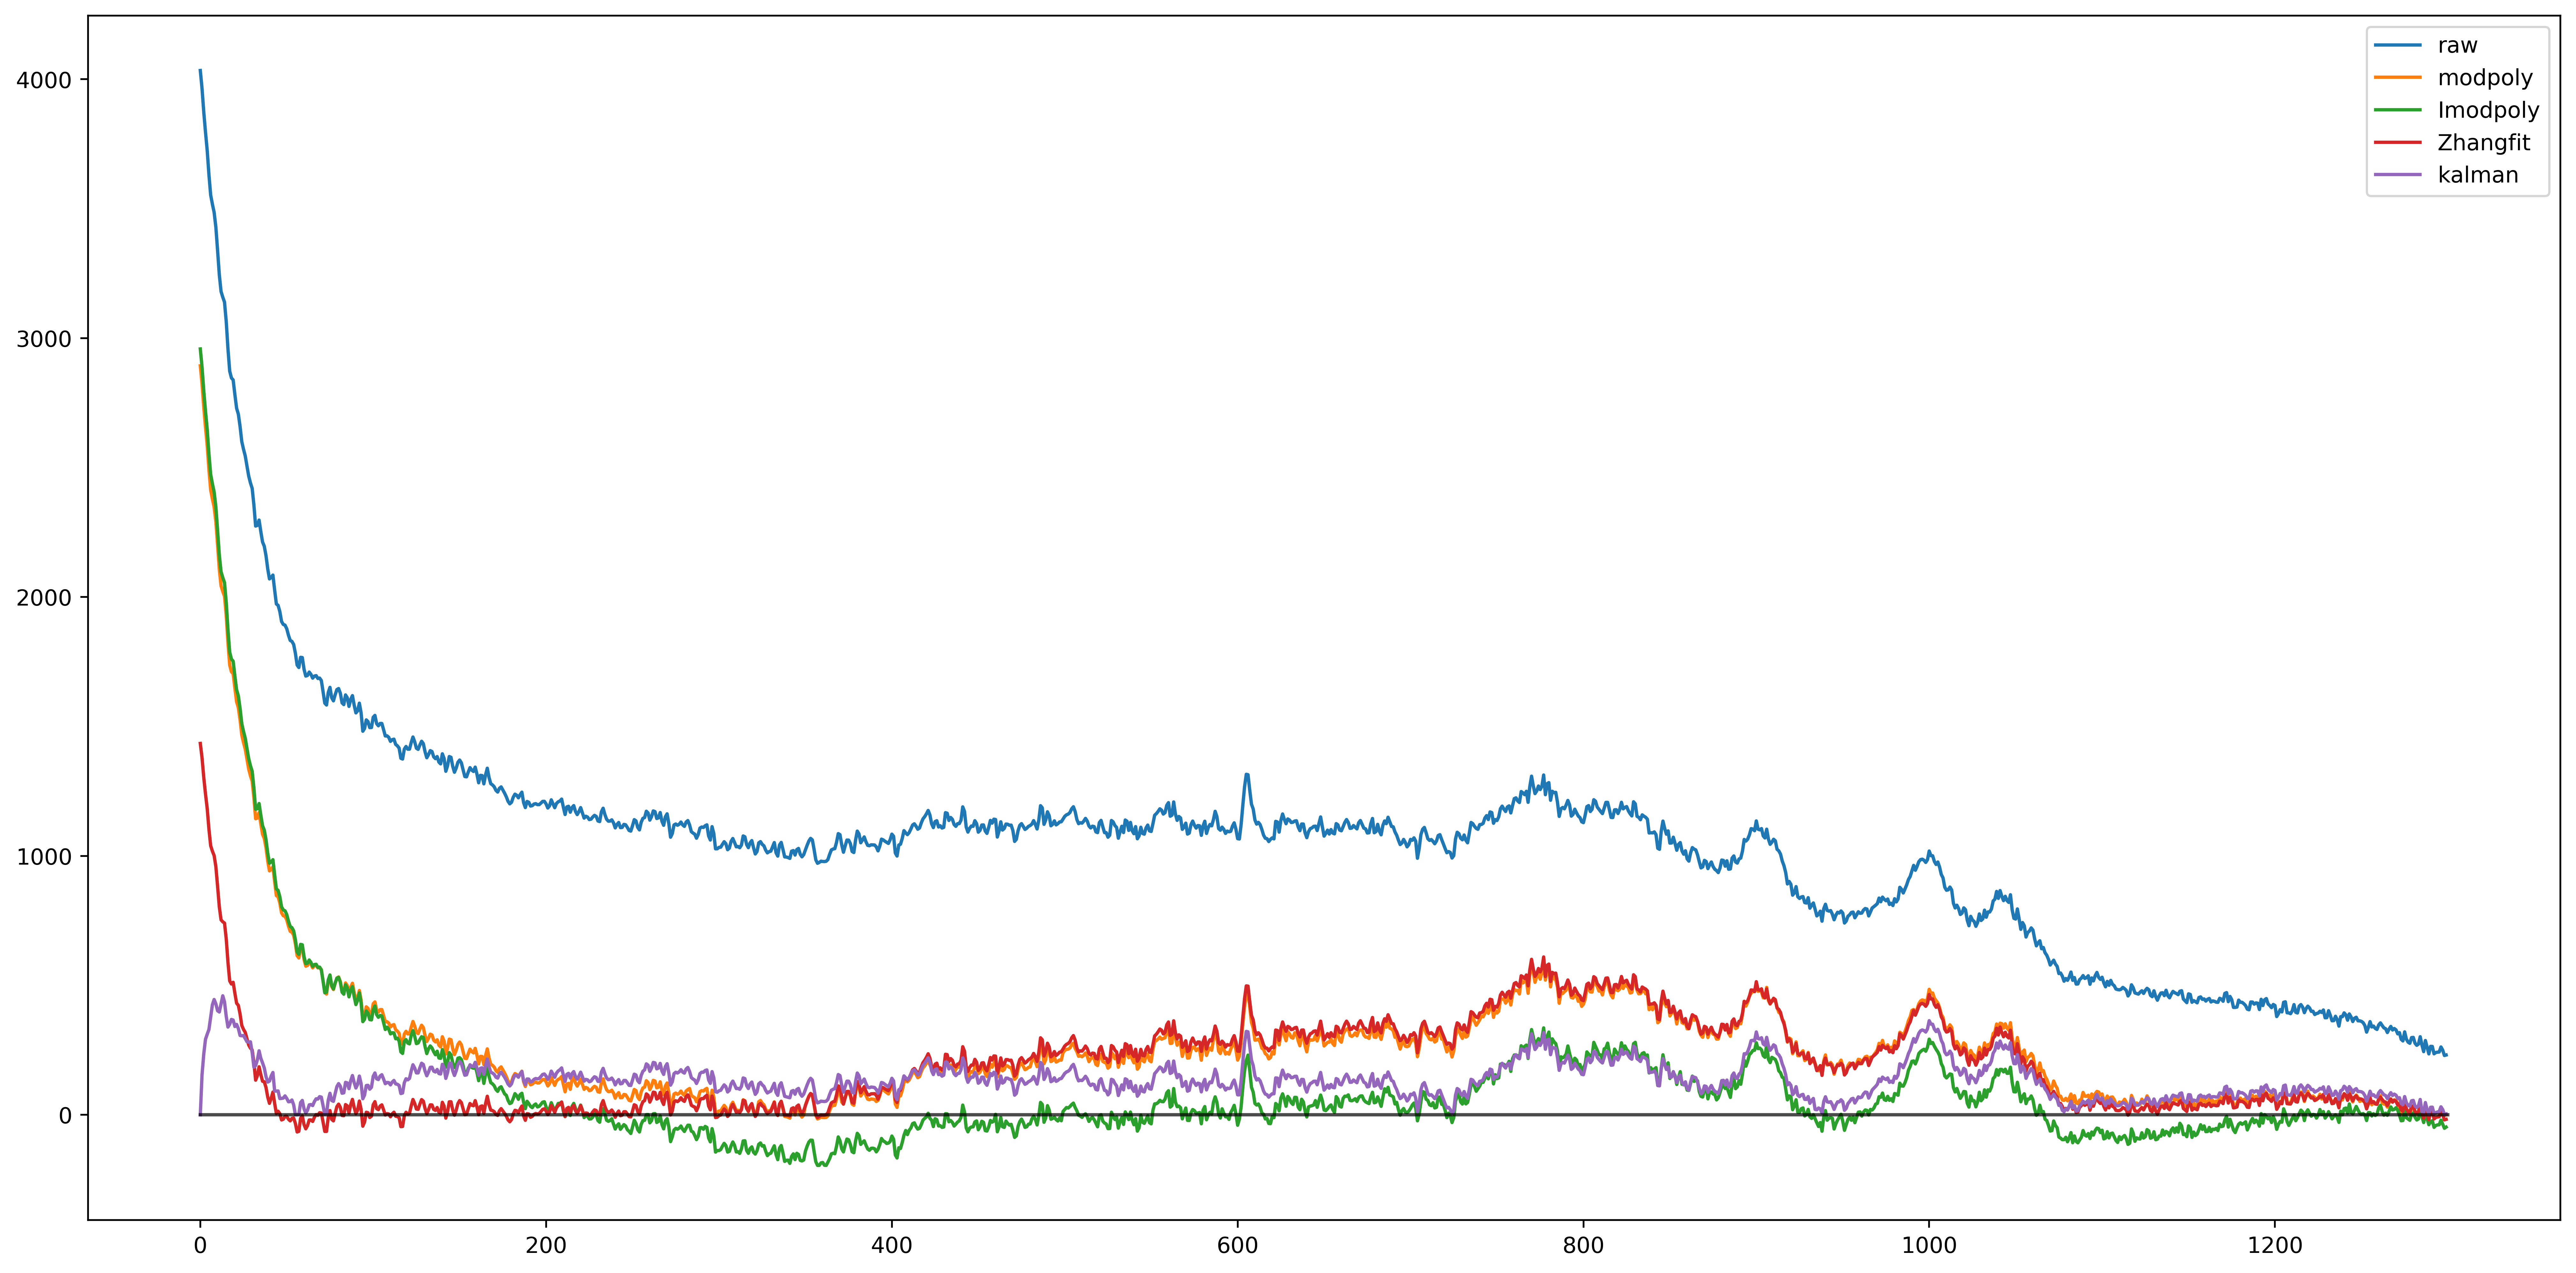

In [7]:
plt.plot(x[pixel], label='raw')
plt.plot(Modpoly_output, label='modpoly')
plt.plot(Imodpoly_output, label='Imodpoly')
plt.plot(Zhangfit_output, label='Zhangfit')
plt.plot(obj.mu[:,1], label='kalman')
plt.plot([0,1300],[0,0], 'k', alpha=0.7)

plt.legend()
plt.show()

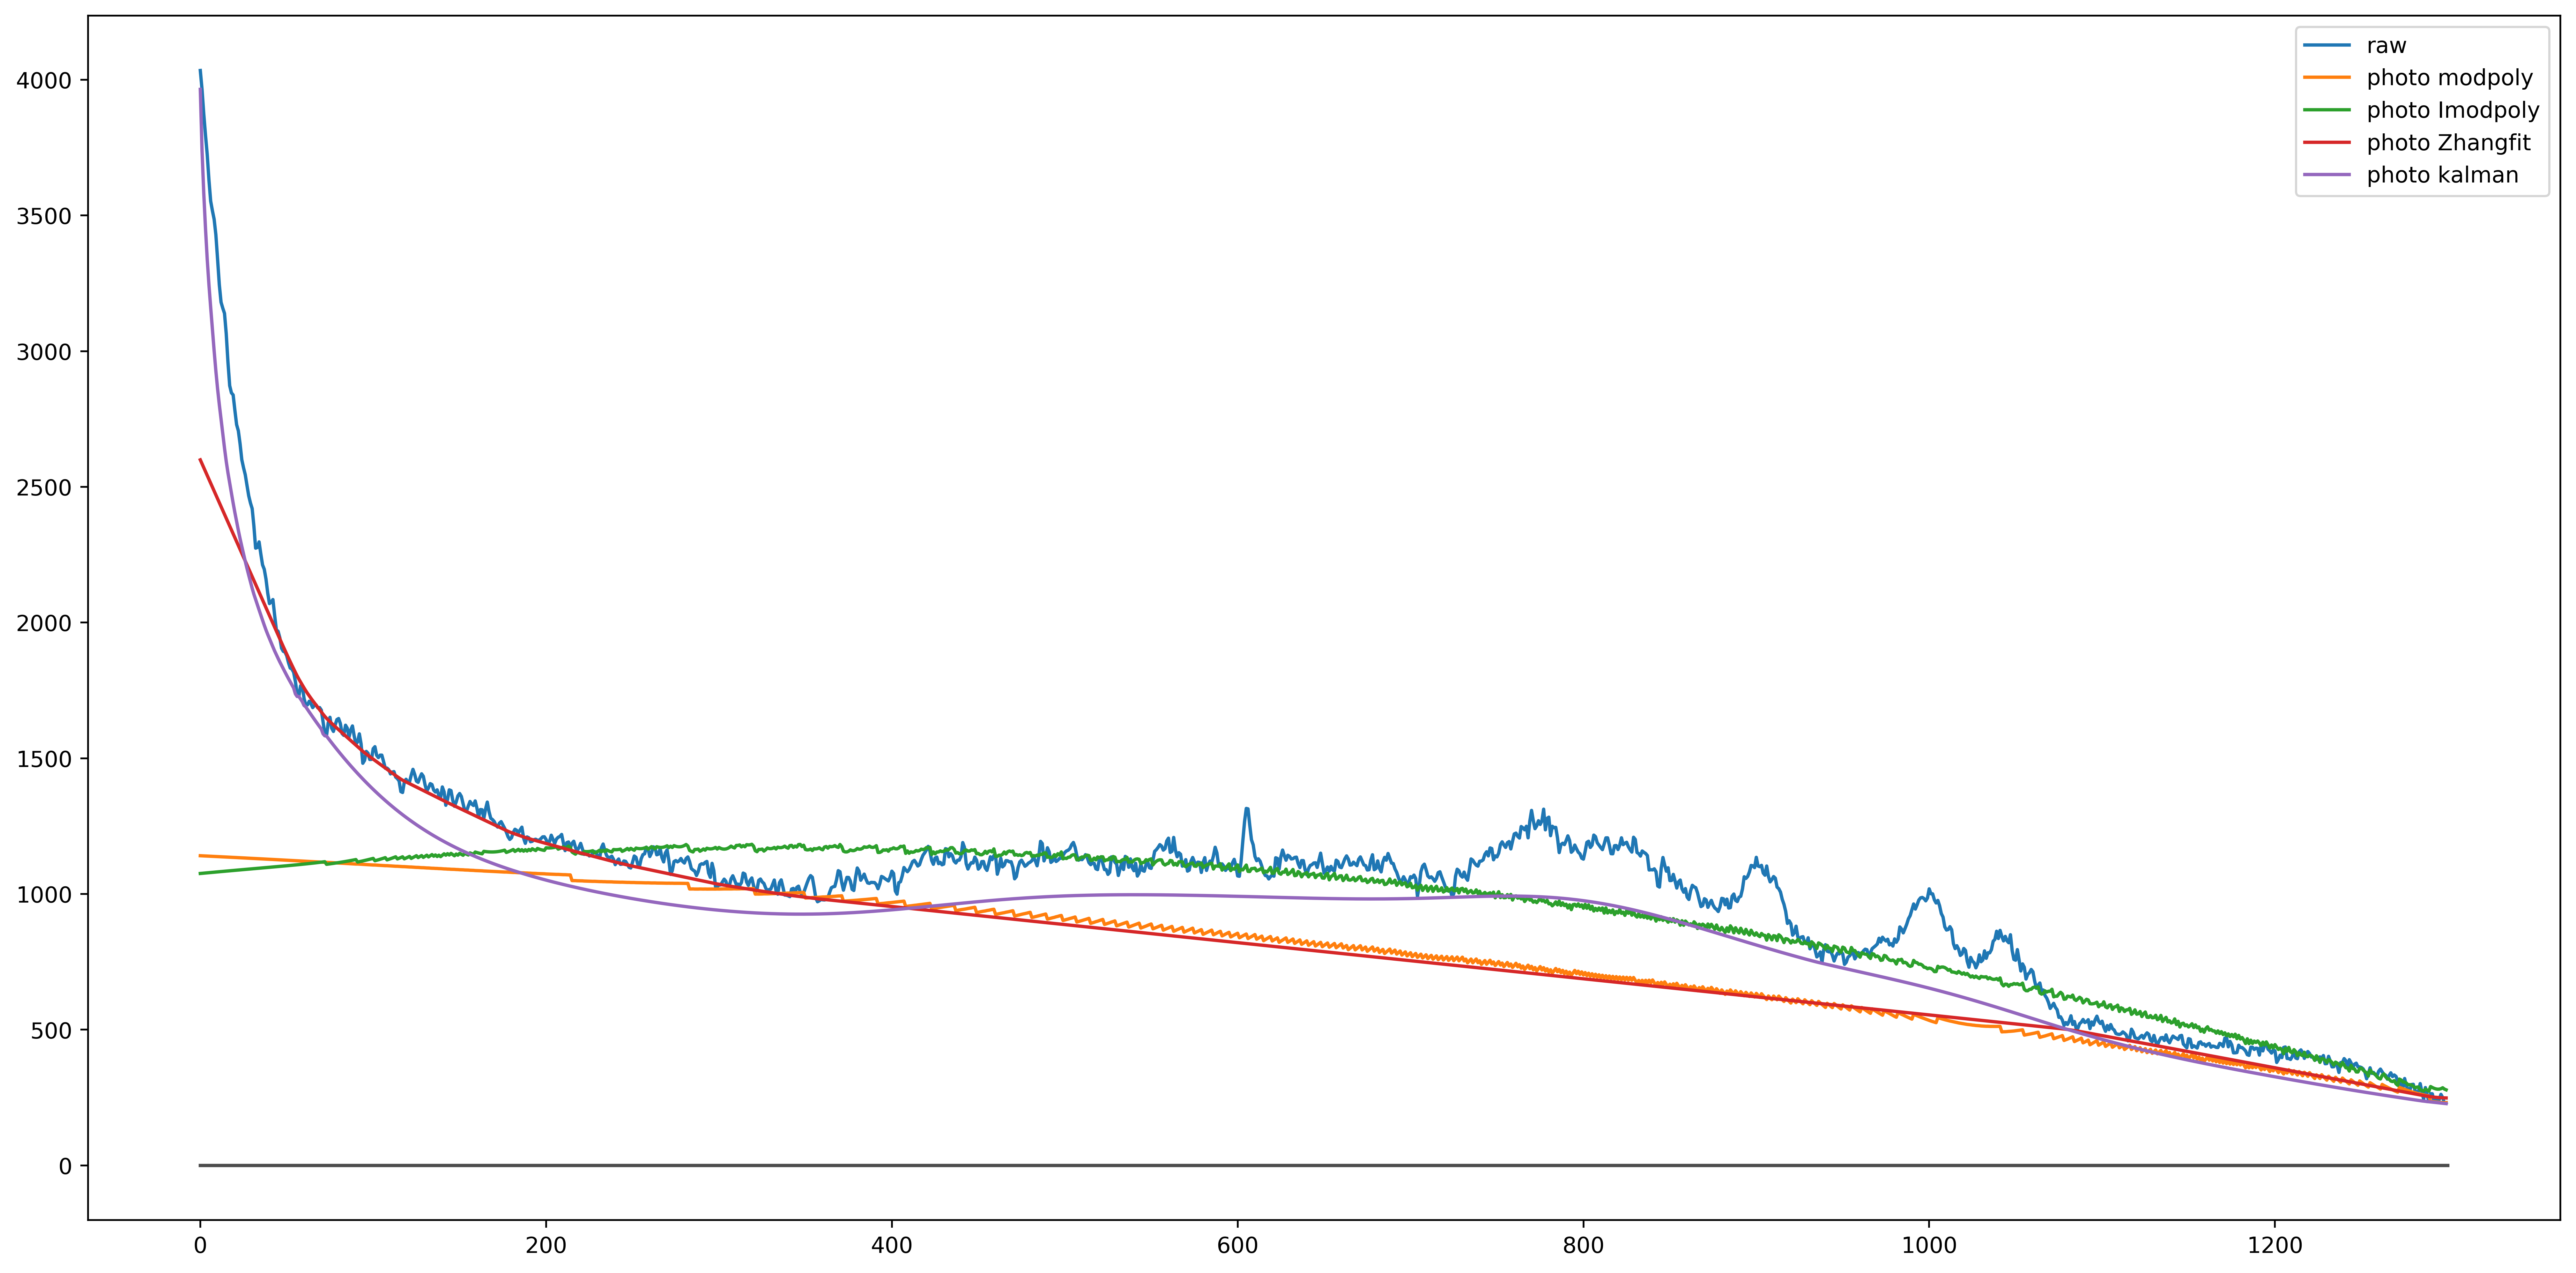

In [8]:
plt.plot(x[pixel], label='raw')
plt.plot(x[pixel]-Modpoly_output, label='photo modpoly')
plt.plot(x[pixel]-Imodpoly_output, label='photo Imodpoly')
plt.plot(x[pixel]-Zhangfit_output, label='photo Zhangfit')
plt.plot(obj.mu[:,0], label='photo kalman')
plt.plot([0,1300],[0,0], 'k', alpha=0.7)

plt.legend()
plt.show()